In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uw-madison-gi-tract-image-segmentation/sample_submission.csv
/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0082_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0113_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0076_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0125_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0016_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0115_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-im

# Library Installation & Loading

In [2]:
!pip install "../input/segmentation-models-pytorch-021/wheels/pretrainedmodels-0.7.4-py3-none-any.whl"
!pip install "../input/segmentation-models-pytorch-021/wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl"
!pip install "../input/segmentation-models-pytorch-021/wheels/timm-0.4.12-py3-none-any.whl"
!pip install "../input/segmentation-models-pytorch-021/wheels/segmentation_models_pytorch-0.2.1-py3-none-any.whl"
!pip install "../input/monai-wheel/monai-0.8.1-202202162213-py3-none-any.whl"

Processing /kaggle/input/segmentation-models-pytorch-021/wheels/pretrainedmodels-0.7.4-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-021/wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-021/wheels/timm-0.4.12-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-021/wheels/segmentation_models_pytorch-0.2.1-py3-none-any.whl
Processing /kaggle/input/monai-wheel/monai-0.8.1-202202162213-py3-none-any.whl


In [3]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
import json

# visualization
import cv2
import matplotlib.pyplot as plt
from skimage import io

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold,StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import timm

#monai
from monai.metrics.utils import get_mask_edges, get_surface_distance

#keras

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# Configurations

In [4]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'v4'
    comment       = 'unet-efficientnet_b0-320x384'
    model_name    = 'Unet'
#     backbone      = 'timm-mobilenetv3_small_minimal_100'
    backbone      = 'efficientnet-b0'
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = 320
    epochs        = 1
    lr            = 2e-3
    num_slices    = 5
    in_channels   = 3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 7
    folds         = [0]
    num_classes   = 3
    thr           = 0.40
#     device        = torch.device("cpu")
    device        = torch.device("cuda")

# Seeding

In [5]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#     Set a fixed value for the hash seed
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# Utilities

In [6]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(mask_img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
#     pixels = img.ravel(order='F')
#     print(type(mask_img))
    pixels = mask_img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    mask_rle = ' '.join(str(x) for x in runs)
    return mask_rle
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_slice(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    #img = cv2.resize(img,(CFG.img_size, CFG.img_size),interpolation = cv2.INTER_AREA)
    return img
def load_5c_img(df, id):
    img = np.zeros((CFG.img_size, CFG.img_size, CFG.in_channels),dtype = np.float32)
    for i, diff in enumerate(range(-(CFG.num_slices//2), CFG.num_slices//2 +1,2)):
        tmp = id.split("_")
        tmp[3] = str(int(tmp[3])+diff).zfill(4)
        id_tmp="_".join(tmp)
        if df["id"].isin([id_tmp]).any().any():
            img[:,:,i] = load_slice(str(df[df["id"]==id_tmp]["image_path"].squeeze()))
        else:
            img[:,:,i] = load_slice(str(df[df["id"]==id]["image_path"].squeeze()))
    max_val = img.max()
    if max_val != 0 :
        img /= max_val
    return img
def load_slice_other(img_file, diff):
    slice_num = os.path.basename(img_file).split('_')[1]
    filename = (
        img_file.replace(
            'slice_' + slice_num,
            'slice_' + str(int(slice_num) + diff).zfill(4)))
    if os.path.exists(filename):
        return cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    return cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
def load_5c_img_other(img_file):
    imgs = [load_slice_other(img_file, i) for i in range(-2, 3,2)]
    img = np.stack(imgs, axis=2)
    img = img.astype(np.float32)
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

# Metadata

In [7]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
#     row['id'] = f'case{case}_day{day}_slice_{slice_}'
    return row

In [8]:
df=pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
df = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index()
print(df.head())
order=["large_bowel","small_bowel","stomach"]

df = df.progress_apply(get_metadata, axis=1)
print(df.head())

paths = glob('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.progress_apply(path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()

                         id     segmentation
0  case101_day20_slice_0001  [nan, nan, nan]
1  case101_day20_slice_0002  [nan, nan, nan]
2  case101_day20_slice_0003  [nan, nan, nan]
3  case101_day20_slice_0004  [nan, nan, nan]
4  case101_day20_slice_0005  [nan, nan, nan]


100%|██████████| 38496/38496 [00:55<00:00, 692.54it/s]


                         id     segmentation  case  day  slice
0  case101_day20_slice_0001  [nan, nan, nan]   101   20      1
1  case101_day20_slice_0002  [nan, nan, nan]   101   20      2
2  case101_day20_slice_0003  [nan, nan, nan]   101   20      3
3  case101_day20_slice_0004  [nan, nan, nan]   101   20      4
4  case101_day20_slice_0005  [nan, nan, nan]   101   20      5


100%|██████████| 38496/38496 [01:27<00:00, 438.30it/s]


id     segmentation  case  day  slice  \
0  case101_day20_slice_0001  [nan, nan, nan]   101   20      1   
1  case101_day20_slice_0002  [nan, nan, nan]   101   20      2   
2  case101_day20_slice_0003  [nan, nan, nan]   101   20      3   
3  case101_day20_slice_0004  [nan, nan, nan]   101   20      4   
4  case101_day20_slice_0005  [nan, nan, nan]   101   20      5   

                                          image_path  height  width  
0  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266  
1  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266  
2  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266  
3  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266  
4  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266

# Mask creation + dataset creation

In [9]:
def id2mask(id_):
    idf = df[df['id']==id_]
    shape = (df[df['id']==id_]["height"].squeeze(), idf["width"].squeeze(), 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, rle in enumerate(idf["segmentation"].squeeze()):
        if pd.notnull(rle):
            mask[:,:, i] = rle_decode(rle, shape[:2])
    return mask

# print(id2mask("case123_day20_slice_0066"))

In [10]:

def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        encoder_weights= None,
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
        decoder_attention_type='scse',
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [11]:
model_path="../input/uwmgi/last_epoch-00.bin"
model = load_model(model_path)

In [12]:
def show_comparision(ID):
    path = df[df["id"]==ID]["image_path"].squeeze()
    img = load_img(path)
    mask = id2mask(ID)
    img = cv2.resize(img,(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_NEAREST)
    mask = cv2.resize(mask,(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_NEAREST)

    plt.subplot(1,2,1)
    plt.title("Actual annotation")
    plt.imshow(img)
    plt.imshow(mask*255, alpha = 0.5)
    
    img = cv2.resize(img,(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_NEAREST)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).to(CFG.device, dtype=torch.float)
    out   = model(img)
    
    out=out.cpu().detach().numpy()
    img=img.cpu().detach().numpy()
    
    plt.subplot(1,2,2)
    plt.title("Predicted segmentation")
    plt.imshow(np.transpose(img[0],(1,2,0)))
    plt.imshow(np.transpose(out[0],(1,2,0))*255, alpha = 0.5)

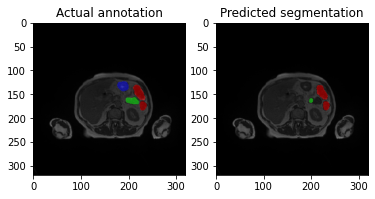

In [13]:
show_comparision("case131_day0_slice_0066")

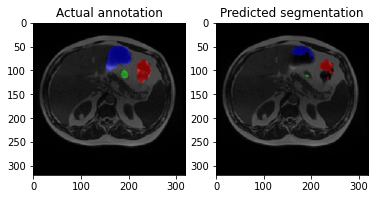

In [14]:
ID = "case123_day20_slice_0082"
show_comparision(ID)

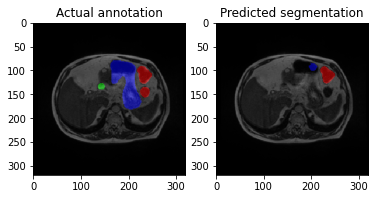

In [15]:
ID = "case117_day16_slice_0029"
show_comparision(ID)

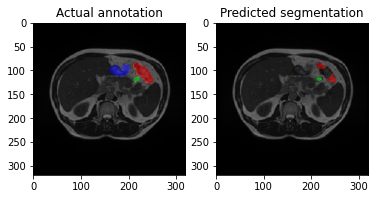

In [16]:
ID = "case20_day0_slice_0077"
show_comparision(ID)

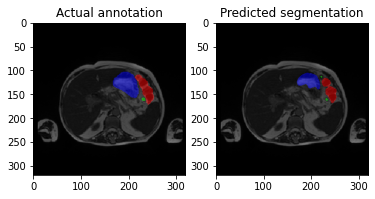

In [17]:
ID = "case135_day17_slice_0060"
show_comparision(ID)